In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
import tensorflow as tf

# Reproducibility
tf.random.set_seed(42)
np.random.seed(42)


/tmp/ipython-input-2240704752.py:5: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(stock_symbol, start="2015-01-01", end="2025-10-10")
[*********************100%***********************]  1 of 1 completed


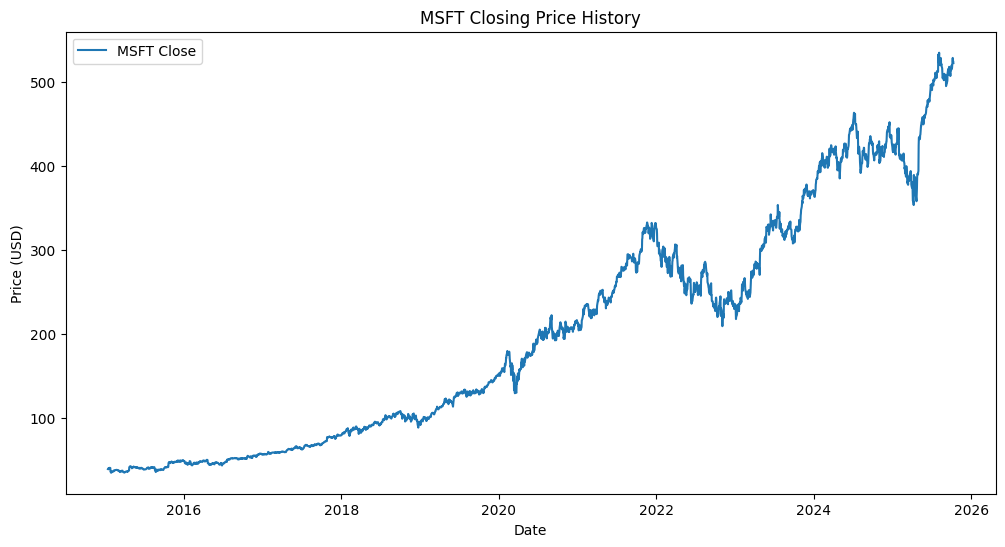

In [ ]:
# -------------------------
# 1) Load data & features
# -------------------------
stock_symbol = "MSFT"
data = yf.download(stock_symbol, start="2015-01-01", end="2025-10-10")

# Feature engineering
data['MA10'] = data['Close'].rolling(window=10).mean()
data['Return'] = data['Close'].pct_change()
data.dropna(inplace=True)

features = ['Close', 'MA10', 'Return']
n_features = len(features)

# Plot closing price history
plt.figure(figsize=(12, 6))
plt.plot(data['Close'], label=f"{stock_symbol} Close")
plt.title(f"{stock_symbol} Closing Price History")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.show()


In [ ]:
# -------------------------
# 2) Scale features
# -------------------------
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data[features].values)

# Separate scaler for Close column (for easy inverse transform)
close_scaler = MinMaxScaler(feature_range=(0, 1))
close_scaler.fit(data[['Close']].values)


MinMaxScaler()

In [ ]:
# -------------------------
# 3) Create sequences
# -------------------------
def create_dataset_multi_features(scaled_array, time_step=60):
    X, y = [], []
    for i in range(time_step, len(scaled_array)):
        X.append(scaled_array[i - time_step:i, :])
        y.append(scaled_array[i, 0])  # target = Close
    return np.array(X), np.array(y)

time_step = 60
X, y = create_dataset_multi_features(scaled_data, time_step=time_step)

n_samples = X.shape[0]
split_idx = int(n_samples * 0.8)

X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

# ANN uses flattened input
X_train_ann = X_train.reshape((X_train.shape[0], time_step * n_features))
X_test_ann  = X_test.reshape((X_test.shape[0],  time_step * n_features))

# LSTM keeps 3D input
X_train_lstm = X_train.copy()
X_test_lstm  = X_test.copy()


In [ ]:
# -------------------------
# 4) ANN model
# -------------------------
ann_model = Sequential([
    Dense(128, activation='relu', input_shape=(time_step * n_features,)),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dense(1)
])
ann_model.compile(optimizer='adam', loss='mse')
ann_model.summary()

history_ann = ann_model.fit(
    X_train_ann, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.1,
    verbose=1
)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_27 (Dense)                │ (None, 128)            │        23,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,489 (123.00 KB)

 Trainable params: 31,489 (123.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0713 - val_loss: 0.0053
Epoch 2/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0031 - val_loss: 0.0097
Epoch 3/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0022 - val_loss: 0.0121
Epoch 4/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0019 - val_loss: 0.0130
Epoch 5/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0014 - val_loss: 0.0115
Epoch 6/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0014 - val_loss: 0.0152
Epoch 7/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0012 - val_loss: 0.0141
Epoch 8/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 9.8699e-04 - val_loss: 0.0123
Epoch 9/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 9.3054e-04 - val_loss: 0.0132
Epoch 10/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.9209e-04 - val_loss: 0.0106
Epoch 11/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.8117e-04 - val_loss: 0.0110
Epoch 12/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss:

In [ ]:
# -------------------------
# 5) LSTM model
# -------------------------
lstm_model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(time_step, n_features)),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(25, activation='relu'),
    Dense(1)
])
lstm_model.compile(optimizer='adam', loss='mse')
lstm_model.summary()

history_lstm = lstm_model.fit(
    X_train_lstm, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.1,
    verbose=1
)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_12 (LSTM)                  │ (None, 60, 50)         │        10,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_13 (LSTM)                  │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,301 (126.18 KB)

 Trainable params: 32,301 (126.18 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 9s 87ms/step - loss: 0.0188 - val_loss: 0.0061
Epoch 2/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - loss: 0.0014 - val_loss: 0.0031
Epoch 3/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - loss: 9.5135e-04 - val_loss: 0.0028
Epoch 4/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 69ms/step - loss: 8.0554e-04 - val_loss: 0.0048
Epoch 5/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 5s 72ms/step - loss: 6.9566e-04 - val_loss: 0.0020
Epoch 6/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 101ms/step - loss: 5.7805e-04 - val_loss: 0.0027
Epoch 7/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 62ms/step - loss: 6.4670e-04 - val_loss: 0.0032
Epoch 8/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - loss: 6.0235e-04 - val_loss: 0.0026
Epoch 9/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 70ms/step - loss: 5.5131e-04 - val_loss: 0.0027
Epoch 10/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - loss: 5.3483e-04 - val_loss: 0.0034
Epoch 11/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - loss: 5.2742e-04 - val_loss: 0.0024
Epoch 12/50
60/60 ━━━━━━━━

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step
ANN RMSE : 83.9208
LSTM RMSE: 54.9775


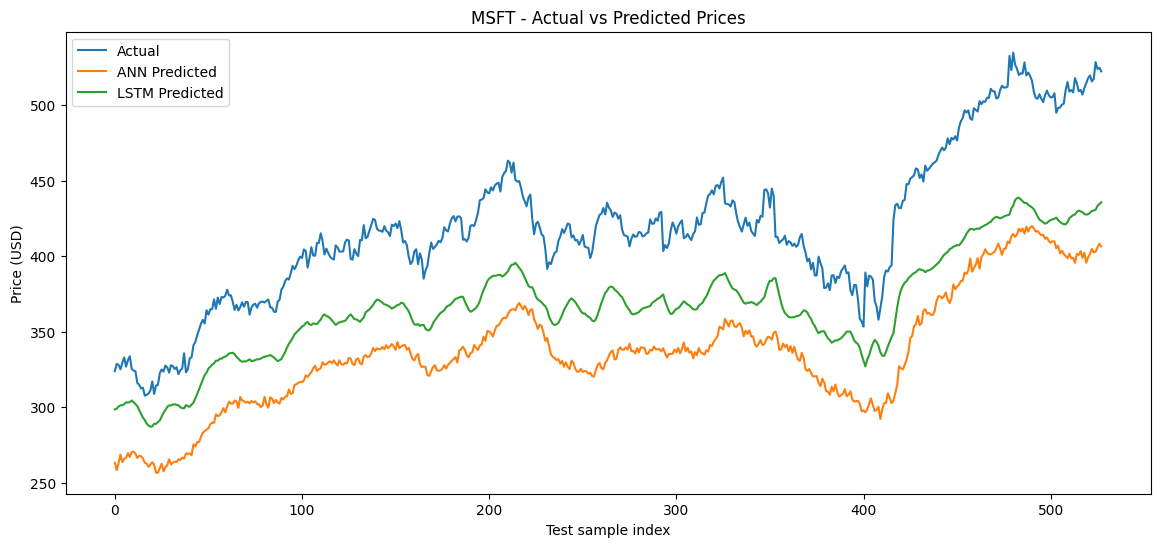

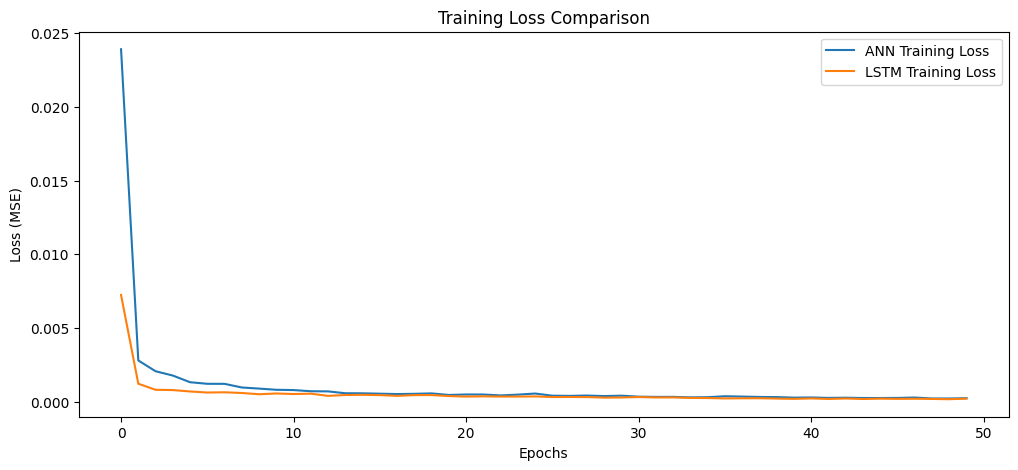

In [ ]:
# -------------------------
# 6) Evaluate & predict
# -------------------------
ann_pred_scaled  = ann_model.predict(X_test_ann)
lstm_pred_scaled = lstm_model.predict(X_test_lstm)

# Inverse transform
ann_pred_actual  = close_scaler.inverse_transform(ann_pred_scaled)
lstm_pred_actual = close_scaler.inverse_transform(lstm_pred_scaled)
y_test_actual    = close_scaler.inverse_transform(y_test.reshape(-1, 1))

ann_rmse  = np.sqrt(mean_squared_error(y_test_actual, ann_pred_actual))
lstm_rmse = np.sqrt(mean_squared_error(y_test_actual, lstm_pred_actual))

print(f"ANN RMSE : {ann_rmse:.4f}")
print(f"LSTM RMSE: {lstm_rmse:.4f}")

# Plot Actual vs Predicted
plt.figure(figsize=(14, 6))
plt.plot(y_test_actual, label='Actual')
plt.plot(ann_pred_actual, label='ANN Predicted')
plt.plot(lstm_pred_actual, label='LSTM Predicted')
plt.title(f"{stock_symbol} - Actual vs Predicted Prices")
plt.xlabel("Test sample index")
plt.ylabel("Price (USD)")
plt.legend()
plt.show()

# Plot training loss
plt.figure(figsize=(12, 5))
plt.plot(history_ann.history['loss'], label='ANN Training Loss')
plt.plot(history_lstm.history['loss'], label='LSTM Training Loss')
plt.title("Training Loss Comparison")
plt.xlabel("Epochs")
plt.ylabel("Loss (MSE)")
plt.legend()
plt.show()


In [ ]:
# -------------------------
# 7) Future prediction (next day)
# -------------------------
last_60 = scaled_data[-time_step:]
input_for_lstm = last_60.reshape(1, time_step, n_features)
pred_scaled_next = lstm_model.predict(input_for_lstm)
pred_actual_next = close_scaler.inverse_transform(pred_scaled_next)

last_date = data.index[-1].date()
next_date = last_date + pd.Timedelta(days=1)
print(f"Last date: {last_date}")
print(f"Predicted next-day closing price ({next_date}): ${pred_actual_next[0,0]:.2f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Last date: 2025-10-09
Predicted next-day closing price (2025-10-10): $435.83


In [ ]:
# -------------------------
# 8) Spot-check a date in test set
# -------------------------
test_start_idx_in_data = time_step + split_idx
test_dates = data.index[test_start_idx_in_data : test_start_idx_in_data + len(y_test)]

target_date = pd.to_datetime('2025-10-09')
if target_date in test_dates:
    idx = list(test_dates).index(target_date)
    print("Spot-check:", target_date.date())
    print("Actual :", y_test_actual[idx][0])
    print("LSTM   :", lstm_pred_actual[idx][0])
    print("ANN    :", ann_pred_actual[idx][0])
else:
    print(f"{target_date.date()} not in test_dates (maybe weekend/holiday).")


Spot-check: 2025-10-09
Actual : 522.4000244140625
LSTM   : 435.59088
ANN    : 406.37372


In [ ]:
from sklearn.metrics import mean_absolute_error, r2_score

# Calculate other metrics
ann_mae  = mean_absolute_error(y_test_actual, ann_pred_actual)
lstm_mae = mean_absolute_error(y_test_actual, lstm_pred_actual)

ann_r2  = r2_score(y_test_actual, ann_pred_actual)
lstm_r2 = r2_score(y_test_actual, lstm_pred_actual)

ann_mape  = np.mean(np.abs((y_test_actual - ann_pred_actual) / y_test_actual)) * 100
lstm_mape = np.mean(np.abs((y_test_actual - lstm_pred_actual) / y_test_actual)) * 100

print("\n📊 Model Performance Comparison:")
print("------------------------------------------------")
print(f"{'Model':<10}{'RMSE':>10}{'MAE':>10}{'R²':>10}{'MAPE(%)':>12}")
print("------------------------------------------------")
print(f"{'ANN':<10}{ann_rmse:>10.4f}{ann_mae:>10.4f}{ann_r2:>10.4f}{ann_mape:>12.2f}")
print(f"{'LSTM':<10}{lstm_rmse:>10.4f}{lstm_mae:>10.4f}{lstm_r2:>10.4f}{lstm_mape:>12.2f}")
print("------------------------------------------------")

# Decide which model is better
if lstm_rmse < ann_rmse and lstm_r2 > ann_r2:
    print("\n✅ LSTM performs better overall (lower error, higher R²).")
else:
    print("\n✅ ANN performs better overall.")



📊 Model Performance Comparison:
------------------------------------------------
Model           RMSE       MAE        R²     MAPE(%)
------------------------------------------------
ANN          83.9208   82.3425   -1.7287       19.57
LSTM         54.9775   52.0872   -0.1711       12.15
------------------------------------------------

✅ LSTM performs better overall (lower error, higher R²).
